# Example Implementation of an Incremental Classifier for Prediction on the Graz Dataset


The Graz Dataset frequency sampling rate is 250Hz/512Hz (depending on the version). The data is stored as a 3d array and can be better understaood by simply printing to console. In general, thee data contains details of trials against EEG recordings accross different channels. Every 2d array is a single experiment. Every experiment has the eeg recordings, trials, labels and corresponding sampling frequency. The sampling frequency is homogenous.

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt 

import sys, os, os.path

import numpy as np
from utils import dataset, graz

import signal_processing.signal

import matplotlib.pyplot as plt 
from plotting.plot import plot_brain_signals, plot_spectral_representation

import utils.extract, utils.dwt, utils.features, utils.split
from reporting.report import normal_data_split_report, incremental_data_split_report, normalized_data_report

import classifier.base_classifier, classifier.svm
from classifier.incremental_classifier import IncrementalClassifier
from algorithm import learn_pp

from utils.models_utils import load_model, save_model

## Load Data

Data can be downloaded from: http://bnci-horizon-2020.eu/database/data-sets

All parameters are specific to the data being used. Additional documentation supporting data is provided with necessary and required values.

In [2]:
data_dir= "/home/eeshakumar/work/idp/code/bci-incremental-learning/data"
graz_data_dir= os.path.join(data_dir, "graz_data")
subject = 'A01'
trial_len = 8
cue_interval = [2, 6]
# Cue starts at 2s
cue_offset = 0
sampling_freq = 250

graz_data = graz.GrazA(graz_data_dir, subject, trial_len, cue_interval, cue_offset, sampling_freq)
graz_data.load()
graz_data.print_stats()
labels=graz_data.labels

EEG data shape : (483675, 5)
Labels shape : (240,)
Trials shape : (240,)
Trial Length : 8
Sampling frequency : 250
Cue Interval : [2, 6]
Number of classes : [0 1 2 3]


## Band-pass Filter

In [7]:
lowcut=10
highcut=70

btr_data = signal_processing.signal.butter_bandpass(graz_data, lo=lowcut, hi=highcut)

## Plot Brain Signals

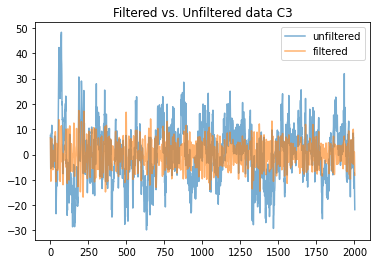

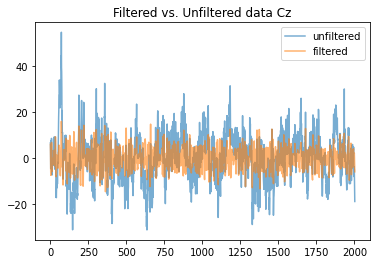

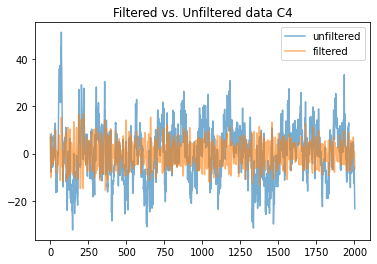

In [8]:
#By default the plot plots the first trial.
#0 C3, 1 Cz, 2 C4
plot_brain_signals(graz_data, btr_data, 0, title="Filtered vs. Unfiltered data C3")
plot_brain_signals(graz_data, btr_data, 1, title="Filtered vs. Unfiltered data Cz")
plot_brain_signals(graz_data, btr_data, 2, title="Filtered vs. Unfiltered data C4")

## Extract Trials

In [9]:
# Extract trials for 2class motor imagery data
data_class = utils.extract.extract_trials_4class(graz_data, btr_data)
# c1_idxs = np.where(labels==1)[0]
# c0_idxs = np.where(labels==0)[0]
# c2_idxs = np.where(labels==2)[0]
# c3_idxs = np.where(labels==3)[0]

## Spectrogram
The spectogram plots give a visual understanding of the intensity of potentials measured depending on coinciding frequencies. By default, the plot represents the first trial.

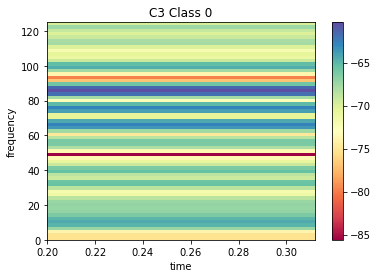

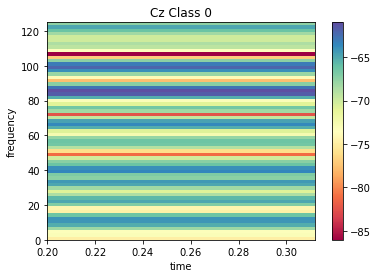

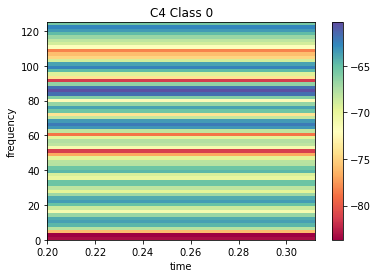

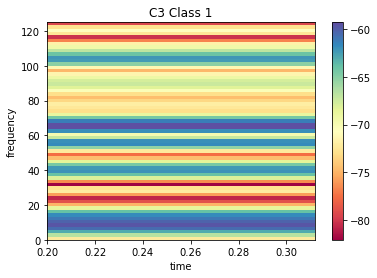

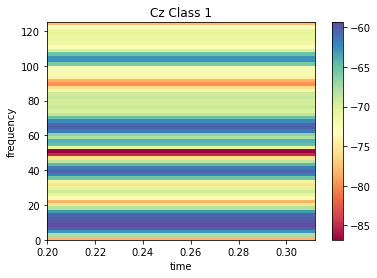

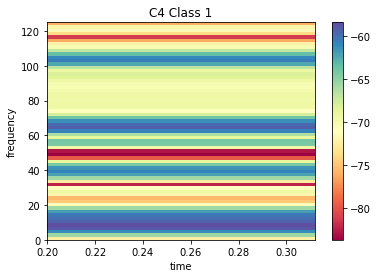

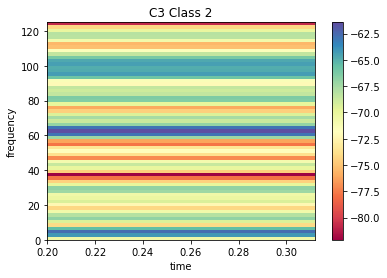

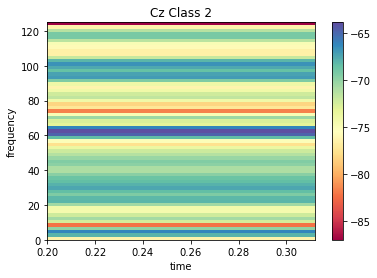

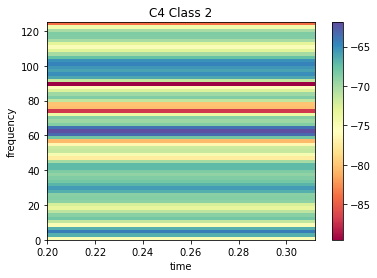

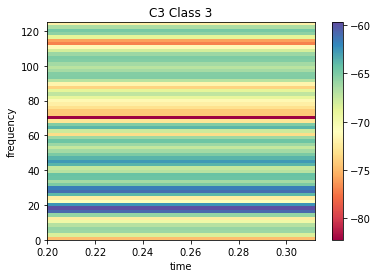

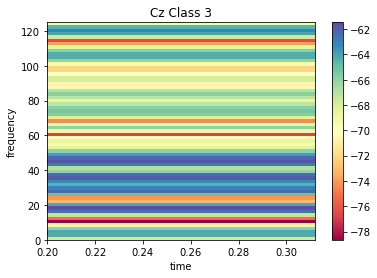

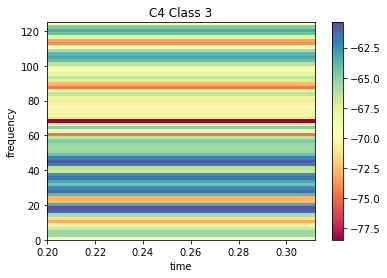

In [10]:
plot_spectral_representation(data_class, 0, graz_data.sampling_freq, 'C3 Class 0')
plot_spectral_representation(data_class, 1, graz_data.sampling_freq, 'Cz Class 0')
plot_spectral_representation(data_class, 2, graz_data.sampling_freq, 'C4 Class 0')
plot_spectral_representation(data_class, 3, graz_data.sampling_freq, 'C3 Class 1')
plot_spectral_representation(data_class, 4, graz_data.sampling_freq, 'Cz Class 1')
plot_spectral_representation(data_class, 5, graz_data.sampling_freq, 'C4 Class 1')
plot_spectral_representation(data_class, 6, graz_data.sampling_freq, 'C3 Class 2')
plot_spectral_representation(data_class, 7, graz_data.sampling_freq, 'Cz Class 2')
plot_spectral_representation(data_class, 8, graz_data.sampling_freq, 'C4 Class 2')
plot_spectral_representation(data_class, 9, graz_data.sampling_freq, 'C3 Class 3')
plot_spectral_representation(data_class, 10, graz_data.sampling_freq, 'Cz Class 3')
plot_spectral_representation(data_class, 11, graz_data.sampling_freq, 'C4 Class 3')

## Feature Extraction

### DWT Sampling
Discrete wavelet transform sampling allows approximation of features and is largely dependent on the sampling frequency.

In [11]:
w = [0, 250]

trials = graz_data.trials
features1= np.array(utils.dwt.dwt_features(btr_data, trials, 5, 250, w, 3, "db4"))
features2= np.array(utils.dwt.dwt_features(btr_data, trials, 5, 250, w, 4, "db4"))
features = np.concatenate((features1.T, features2.T)).T
features -= np.mean(features)
features = utils.features.normalize(features, 'min_max')

## Split Data

In [12]:
test_ratio = 0.2
split_features = np.array(utils.split.normal(features, labels.T, test_ratio=test_ratio, random_state=477))
x_train = split_features[0]
x_test = split_features[1]
y_train = split_features[2]
y_test = split_features[3]
normal_data_split_report(x_train, y_train, x_test, y_test)

Training data size: (192, 24)
Training labels size: (192,)
Test data size: (48, 24)
Test label size: (48,)


## Normalize Data

In [13]:
x_train = utils.features.normalize(x_train, 'mean_std')
x_train = utils.features.normalize(x_train, 'min_max')
normalized_data_report(x_train)

x_test = utils.features.normalize(x_test, 'mean_std')
x_test = utils.features.normalize(x_test, 'min_max')
normalized_data_report(x_test)

Normalized Data:
	Mean: 0.421
	Std dev: 0.104
	Min: 0.000
	Max: 1.000

Normalized Data:
	Mean: 0.413
	Std dev: 0.150
	Min: 0.000
	Max: 1.000



## Regular SVM Classifier

In [14]:
clf = classifier.svm.SVM('linear', 4, 4)
clf.train(x_train, y_train, x_test, y_test)

(<reporting.report.ClassificationReport at 0x7fbb83d959e8>,
 <classifier.svm.SVM at 0x7fbb83d95128>)

## Split Data

In [37]:
test_ratio = 0.2
split_ds = np.array(utils.split.normal(features, labels.T, test_ratio=test_ratio, random_state=477))
x_train = split_ds[0]
x_test = split_ds[1]
y_train = split_ds[2]
y_test = split_ds[3]
ds_features, ds_labels = utils.split.k_way_split(x_train, y_train)
incremental_data_split_report(ds_features, ds_labels, x_test, y_test)

Training data size: (96, 24)
Training labels size: (96,)
Test data size: (48, 24)
Test label size: (48,)

Training data size: (48, 24)
Training labels size: (48,)
Test data size: (48, 24)
Test label size: (48,)

Training data size: (48, 24)
Training labels size: (48,)
Test data size: (48, 24)
Test label size: (48,)



## Normalize Data

In [38]:
for k in range(len(ds_features)):
    ds_features[k] = utils.features.normalize(ds_features[k], 'mean_std')
    ds_features[k] = utils.features.normalize(ds_features[k], 'min_max')
    normalized_data_report(ds_features[k])
    
x_test = utils.features.normalize(x_test , 'mean_std')
x_test = utils.features.normalize(x_test , 'min_max')
normalized_data_report(x_test)

Normalized Data:
	Mean: 0.445
	Std dev: 0.111
	Min: 0.000
	Max: 1.000

Normalized Data:
	Mean: 0.427
	Std dev: 0.185
	Min: 0.000
	Max: 1.000

Normalized Data:
	Mean: 0.409
	Std dev: 0.148
	Min: 0.000
	Max: 1.000

Normalized Data:
	Mean: 0.413
	Std dev: 0.150
	Min: 0.000
	Max: 1.000



## Incremental SVM Classifier
This incremental classifier is a learning algorithm which trains on a base classifier, inour case SVM to improve accuracy. The caveat for such an algorithm is the existence of weak learners.

In [45]:
number_of_classifiers = 1
number_of_classes = 4
inc_clf = IncrementalClassifier(clf, number_of_classifiers, number_of_classes)

learn_pp.learn(inc_clf, 'linear', ds_features, ds_labels, x_test, y_test, sample_ratio=1)

Data Subset 0:
	Classifier Iteration 0:
		epsilon: [0.58333333]
		beta: [1.4]
		Train Accuracy: [41.66666667]
		e_kt: [0.75]
		b_kt: [3.]
		Test Accuracy: [25.]
		Error: [0.72916667]

Data Subset 1:
	Classifier Iteration 1:
		epsilon: [0.33403361]
		beta: [0.50157729]
		Train Accuracy: [64.58333333]
		e_kt: [0.5]
		b_kt: [1.]
		Test Accuracy: [22.91666667]
		Error: [0.75]

Data Subset 2:
	Classifier Iteration 2:
		epsilon: [0.5711575]
		beta: [1.33185841]
		Train Accuracy: [41.66666667]
		e_kt: [0.5]
		b_kt: [1.]
		Test Accuracy: [25.]
		Error: [0.72916667]



## Plot error and accuracy
The plots intent to show the incremental changes in error as well as test accuracy depending on number of classifiers used. 

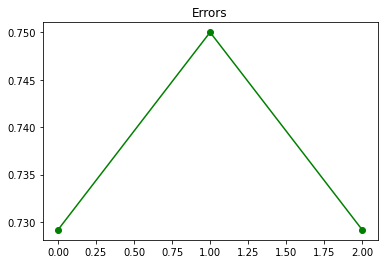

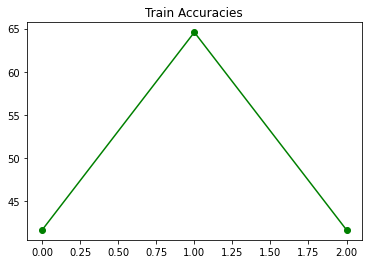

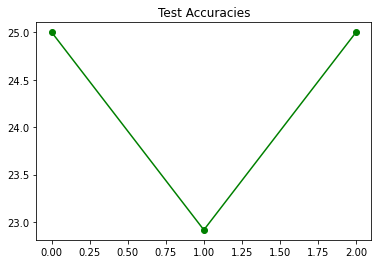

In [46]:
inc_clf.plot_errs()
inc_clf.plot_train_accuracy()
inc_clf.plot_test_accuracy()

## Save Model
Save the model (if needed). Here we save the incremental classifier used to predict in the previous runs.

In [ ]:
models_dir = "/path/to/models"
save_model(inc_clf, models_dir)

## Load Model
Load a saved model. This example loads a saved incremental classifier model.

In [ ]:
models_dir = "/path/to/models"
clf_name = ""
inc_clf = load_model(clf_name, models_dir)